# U-Net on Geospatial Images
This project implements a U-Net model for geospatial image analysis. The goal is to perform high-accuracy segmentation on remote sensing imagery, enabling applications such as land cover classification, change detection, and feature extraction. The model leverages deep learning techniques to efficiently process and segment satellite or aerial images.

#### Connecting Google Drive to Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Installing necessary packages

In [ ]:
!pip install segmentation_models rasterio geopandas contextily tensorflow==2.15

#### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import sys



#### Image and Mask
Let's see what the image and mask datalooks like.

In [ ]:
import os
path='/content/drive/MyDrive/Final Year Project/FinalYearDataset/TrainData/img/image_1.h5'


['img']
Shape:  (128, 128, 14)


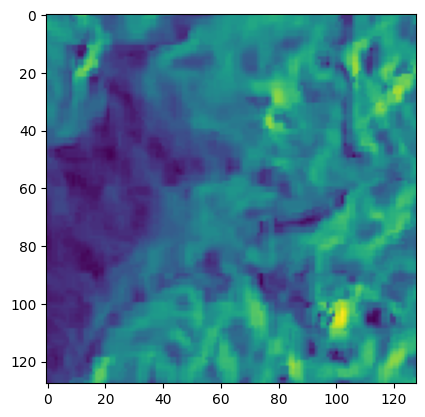

In [ ]:
with h5py.File(path) as hdf:
  ls=list(hdf.keys())
  print(ls)
  data=np.array(hdf.get('img'))
  print("Shape: ", data.shape)
  #plt.imshow(data[:,:,3:0:-1])
  plt.imshow(data[:,:,12])

['mask']
Shape:  (128, 128)


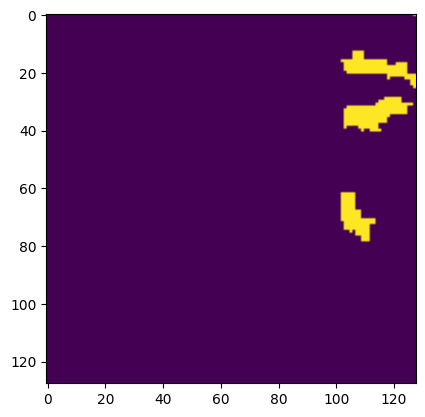

In [ ]:
path='/content/drive/MyDrive/Final Year Project/FinalYearDataset/TrainData/mask/mask_1.h5'
with h5py.File(path) as hdf:
  ls=list(hdf.keys())
  print(ls)
  data=np.array(hdf.get('mask'))
  print("Shape: ", data.shape)
  plt.imshow(data)


Converting images to numpy arrays

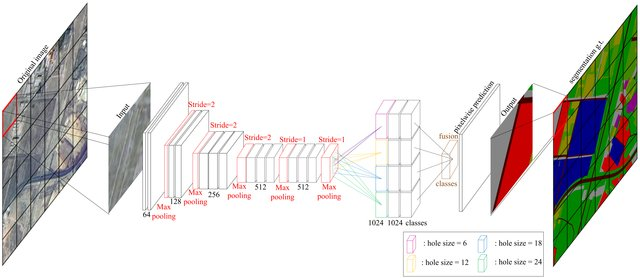

#### Loading the training data

In [ ]:
X_train_uint8 = np.load(f'/content/drive/MyDrive/Final Year Project/FinalYearDataset/TrainData/train_array_uint8.npy')
Y_train_float64 = np.load(f'/content/drive/MyDrive/Final Year Project/FinalYearDataset/TrainData/mask_array_float64.npy')
X_train = np.load(f'/content/drive/MyDrive/Final Year Project/FinalYearDataset/TrainData/train_array.npy')
Y_train = np.load(f'/content/drive/MyDrive/Final Year Project/FinalYearDataset/TrainData/mask_array.npy')
print("Shape of training data (satellite image): ", X_train.shape)
print("Shape of training data (label image): ",Y_train.shape)

Shape of training data (satellite image):  (500, 128, 128, 14)
Shape of training data (label image):  (500, 128, 128)


In [ ]:
print(X_train.dtype, X_train_uint8.dtype)
Y_train.dtype, Y_train_float64.dtype

float64 uint8


(dtype('uint8'), dtype('float64'))

Let's see a few more examples of data

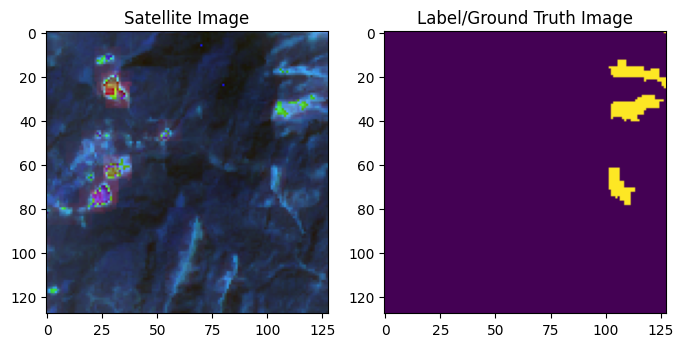

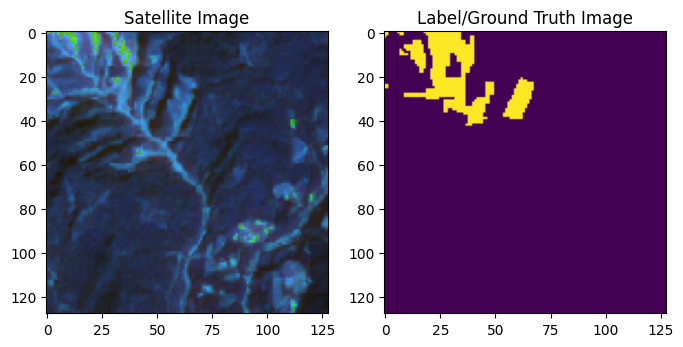

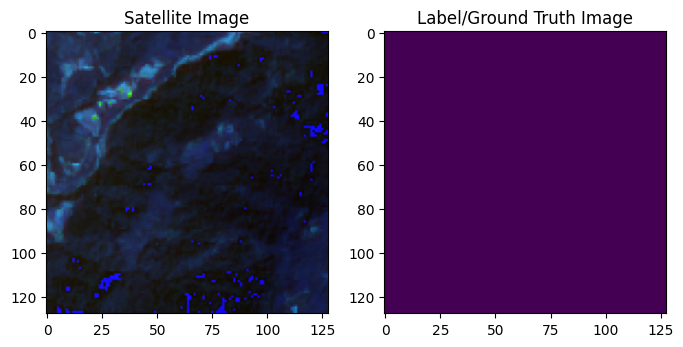

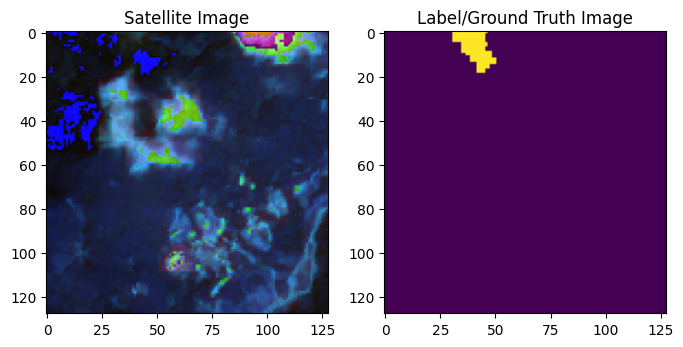

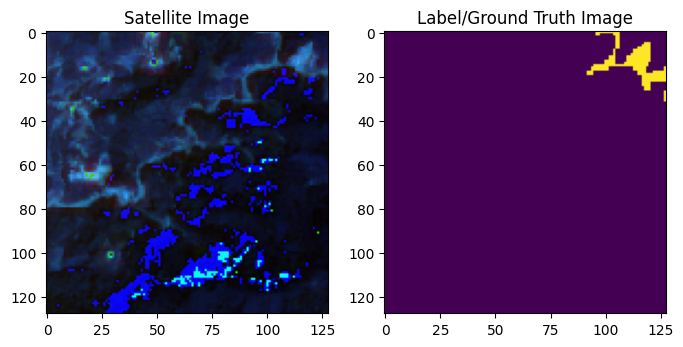

In [ ]:
# Visualise some data
for i in range(5):
    f, axarr = plt.subplots(1,2,figsize=(8,8))
    axarr[0].imshow((X_train_uint8[i][:,:,:3]))
    axarr[0].set_title("Satellite Image")
    axarr[1].imshow(np.squeeze(Y_train[i]))
    axarr[1].set_title("Label/Ground Truth Image")

#### Defining metrics

In [ ]:

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm


# Here we define the evaluation metrics - Precision, Recall, FScore
metrics = [sm.metrics.Precision(threshold=0.5),sm.metrics.Recall(threshold=0.5),sm.metrics.FScore(threshold=0.5,beta=1)]

Segmentation Models: using `tf.keras` framework.


#### Definig loss function

In [ ]:
# Loss function
import tensorflow.keras.backend as K

smooth = 1

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

#### Loading the testing data

In [ ]:

Y_train = Y_train_float64

X_test = np.load(f'/content/drive/MyDrive/Final Year Project/FinalYearDataset/TestnTrain/testX.npy')
Y_test = np.load(f'/content/drive/MyDrive/Final Year Project/FinalYearDataset/TestnTrain/testY.npy')

Y_test = Y_test.astype(np.float64)

X_test.dtype, Y_test.dtype


#### Defining hyperparameters and training

_______________________________________________________________________________
Filters:  4
Learning rate:  0.001
Batch size:  4
Epoch 1/10
100/100 [==============================] - 31s 257ms/step - loss: 0.9320 - precision: 0.0765 - recall: 0.9868 - f1-score: 0.1310 - val_loss: 0.9246 - val_precision: 0.2081 - val_recall: 0.8903 - val_f1-score: 0.3207
Epoch 2/10
100/100 [==============================] - 26s 255ms/step - loss: 0.9104 - precision: 0.2151 - recall: 0.9346 - f1-score: 0.3270 - val_loss: 0.9086 - val_precision: 0.2842 - val_recall: 0.8558 - val_f1-score: 0.4052
Epoch 3/10
100/100 [==============================] - 26s 266ms/step - loss: 0.8662 - precision: 0.2998 - recall: 0.8865 - f1-score: 0.4244 - val_loss: 0.8331 - val_precision: 0.4421 - val_recall: 0.6873 - val_f1-score: 0.5079
Epoch 4/10
100/100 [==============================] - 25s 250ms/step - loss: 0.6051 - precision: 0.3832 - recall: 0.6982 - f1-score: 0.4289 - val_loss: 0.5035 - val_precision: 0.4401 - val_r

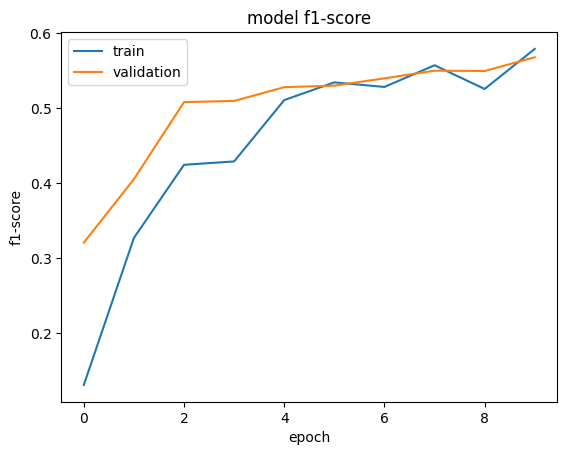

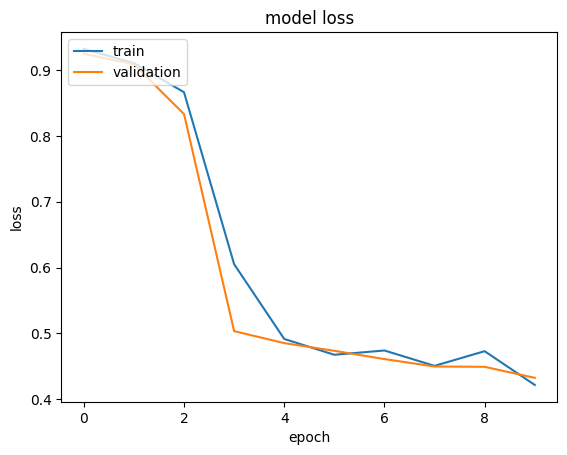

4/4 [==============================] - 3s 599ms/step - loss: 0.2931 - precision: 0.5818 - recall: 0.8456 - f1-score: 0.6877
_______________________________________________________________________________
Filters:  4
Learning rate:  0.0005
Batch size:  4
Epoch 1/10
100/100 [==============================] - 29s 253ms/step - loss: 0.9449 - precision: 0.0299 - recall: 0.9946 - f1-score: 0.0555 - val_loss: 0.9300 - val_precision: 0.0630 - val_recall: 0.9972 - val_f1-score: 0.1126
Epoch 2/10
100/100 [==============================] - 25s 256ms/step - loss: 0.8420 - precision: 0.2307 - recall: 0.8405 - f1-score: 0.2650 - val_loss: 0.6039 - val_precision: 0.3601 - val_recall: 0.6758 - val_f1-score: 0.4450
Epoch 3/10
100/100 [==============================] - 22s 224ms/step - loss: 0.5220 - precision: 0.4486 - recall: 0.6507 - f1-score: 0.4809 - val_loss: 0.5057 - val_precision: 0.5156 - val_recall: 0.5942 - val_f1-score: 0.4987
Epoch 4/10
100/100 [==============================] - 23s 229ms/s

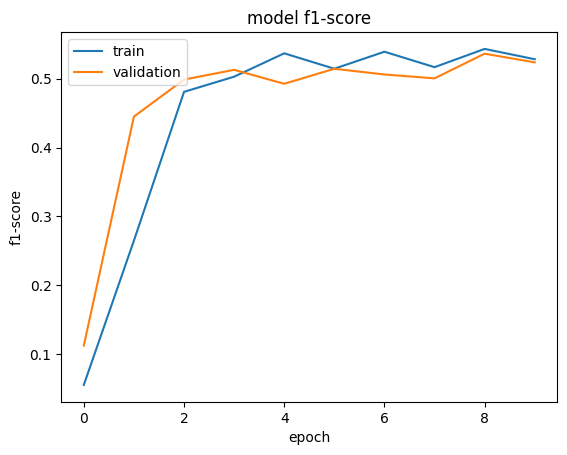

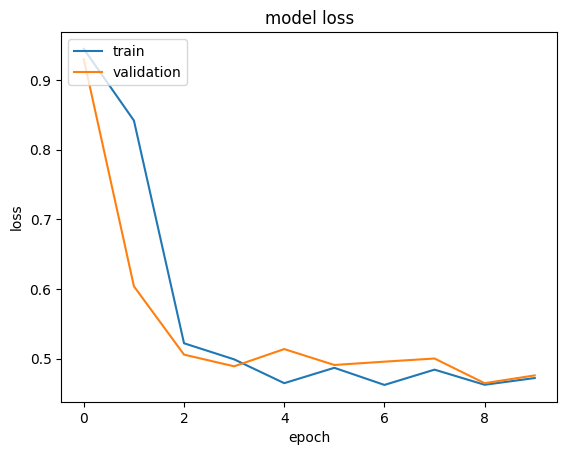

4/4 [==============================] - 3s 567ms/step - loss: 0.3367 - precision: 0.5229 - recall: 0.8584 - f1-score: 0.6473
_______________________________________________________________________________
Filters:  16
Learning rate:  0.001
Batch size:  4
Epoch 1/10
100/100 [==============================] - 78s 743ms/step - loss: 0.9537 - precision: 0.0793 - recall: 0.5118 - f1-score: 0.1133 - val_loss: 0.9957 - val_precision: 0.0200 - val_recall: 2.2505e-05 - val_f1-score: 4.4894e-05
Epoch 2/10
100/100 [==============================] - 70s 695ms/step - loss: 0.9944 - precision: 0.0150 - recall: 0.0200 - f1-score: 7.3165e-05 - val_loss: 0.9957 - val_precision: 0.0200 - val_recall: 2.2505e-05 - val_f1-score: 4.4894e-05
Epoch 3/10
100/100 [==============================] - 68s 677ms/step - loss: 0.9976 - precision: 0.0150 - recall: 2.3793e-05 - f1-score: 4.7473e-05 - val_loss: 0.9957 - val_precision: 0.0200 - val_recall: 2.2505e-05 - val_f1-score: 4.4894e-05
Epoch 4/10
100/100 [=========

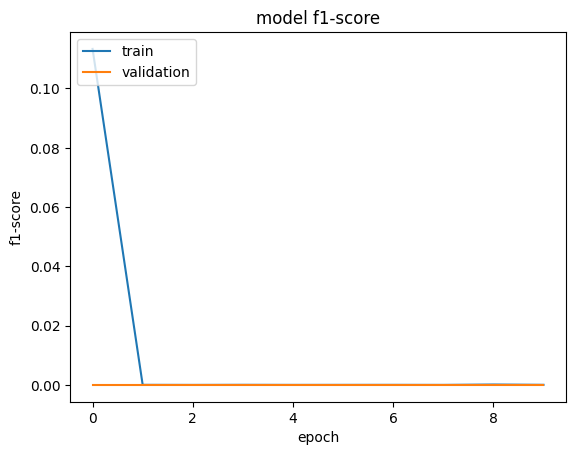

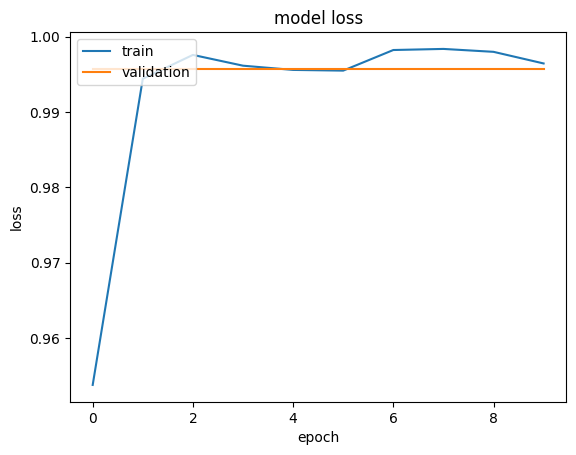

4/4 [==============================] - 4s 711ms/step - loss: 0.9998 - precision: 0.0813 - recall: 1.1501e-04 - f1-score: 2.2967e-04
_______________________________________________________________________________
Filters:  16
Learning rate:  0.0005
Batch size:  4
Epoch 1/10
100/100 [==============================] - 72s 685ms/step - loss: 0.7291 - precision: 0.3036 - recall: 0.5089 - f1-score: 0.3030 - val_loss: 0.5260 - val_precision: 0.4690 - val_recall: 0.5933 - val_f1-score: 0.5013
Epoch 2/10
100/100 [==============================] - 66s 662ms/step - loss: 0.4823 - precision: 0.5466 - recall: 0.6186 - f1-score: 0.5213 - val_loss: 0.4580 - val_precision: 0.5199 - val_recall: 0.6048 - val_f1-score: 0.5449
Epoch 3/10
100/100 [==============================] - 67s 669ms/step - loss: 0.4408 - precision: 0.5875 - recall: 0.6538 - f1-score: 0.5655 - val_loss: 0.4512 - val_precision: 0.5241 - val_recall: 0.6018 - val_f1-score: 0.5479
Epoch 4/10
100/100 [==============================] - 67

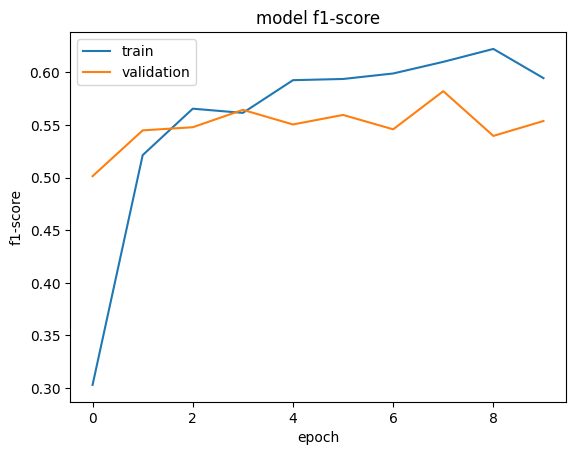

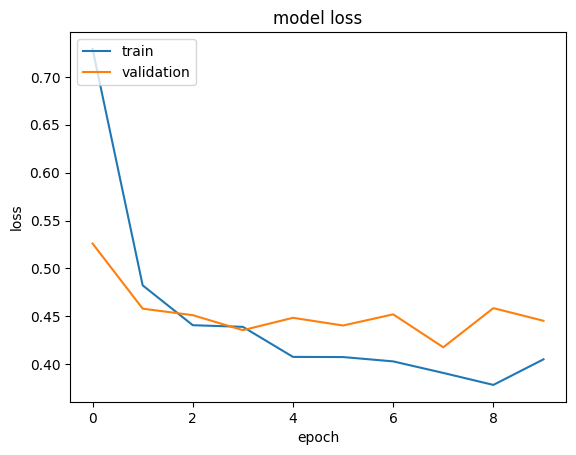

4/4 [==============================] - 4s 712ms/step - loss: 0.3001 - precision: 0.5482 - recall: 0.8950 - f1-score: 0.6774
_______________________________________________________________________________
Filters:  32
Learning rate:  0.001
Batch size:  4
Epoch 1/10
100/100 [==============================] - 170s 2s/step - loss: 0.9205 - precision: 0.2116 - recall: 0.9146 - f1-score: 0.3122 - val_loss: 0.9230 - val_precision: 0.2680 - val_recall: 0.9122 - val_f1-score: 0.3923
Epoch 2/10
100/100 [==============================] - 168s 2s/step - loss: 0.9156 - precision: 0.2728 - recall: 0.9133 - f1-score: 0.3797 - val_loss: 0.9207 - val_precision: 0.2058 - val_recall: 0.9552 - val_f1-score: 0.3213
Epoch 3/10
100/100 [==============================] - 170s 2s/step - loss: 0.9115 - precision: 0.2599 - recall: 0.9308 - f1-score: 0.3811 - val_loss: 0.9173 - val_precision: 0.3210 - val_recall: 0.8842 - val_f1-score: 0.4455
Epoch 4/10
100/100 [==============================] - 170s 2s/step - lo

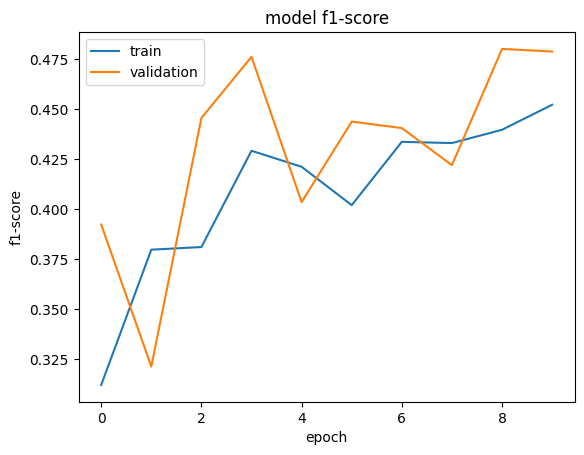

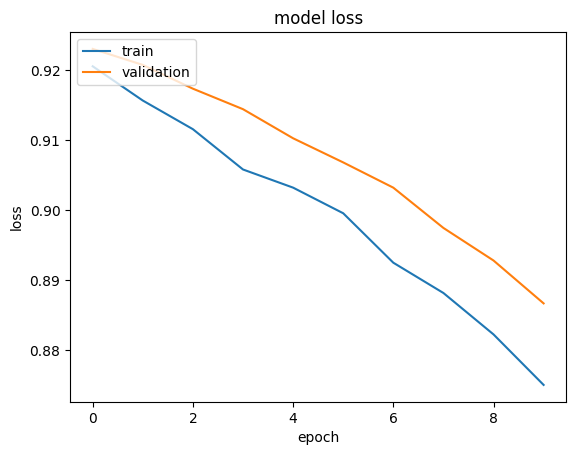

4/4 [==============================] - 11s 2s/step - loss: 0.7492 - precision: 0.4548 - recall: 0.9517 - f1-score: 0.6123
_______________________________________________________________________________
Filters:  32
Learning rate:  0.0005
Batch size:  4
Epoch 1/10
100/100 [==============================] - 162s 2s/step - loss: 0.7192 - precision: 0.4382 - recall: 0.5208 - f1-score: 0.4034 - val_loss: 0.6368 - val_precision: 0.4278 - val_recall: 0.7036 - val_f1-score: 0.5106
Epoch 2/10
100/100 [==============================] - 160s 2s/step - loss: 0.6234 - precision: 0.4984 - recall: 0.6722 - f1-score: 0.5247 - val_loss: 0.6187 - val_precision: 0.5248 - val_recall: 0.5939 - val_f1-score: 0.5388
Epoch 3/10
100/100 [==============================] - 162s 2s/step - loss: 0.5948 - precision: 0.5315 - recall: 0.6842 - f1-score: 0.5624 - val_loss: 0.6061 - val_precision: 0.5024 - val_recall: 0.6234 - val_f1-score: 0.5410
Epoch 4/10
100/100 [==============================] - 162s 2s/step - los

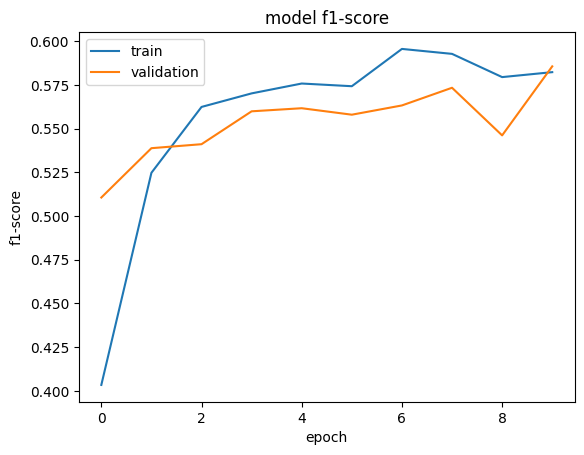

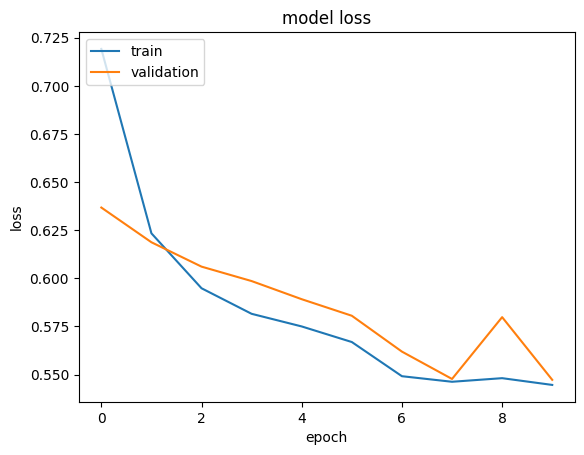

4/4 [==============================] - 11s 2s/step - loss: 0.4194 - precision: 0.6515 - recall: 0.8295 - f1-score: 0.7289


In [ ]:
# Model training - Results are saved in a .csv file

# Size of the tiles
size = X_train.shape[2] # This line takes the value of the 3rd index which in this is taken from X_train shape = 1119, 128, 128, 4, that is 128.

# Image bands
img_bands = X_train.shape[3] # This line takes the value of the 4th index which in this is taken from X_train shape = 1119, 128, 128, 4, that is 4.

# Loss function. We assign the variable called "loss" which takes the dice_loss loss function.
loss=dice_loss

# Number of filters. We set a range of the number of filters for the convolutional layers.
filters = [4, 16, 32] #[4, 8, 16, 32]

# Learning rates for the ADAM optimizer that we use in the model. An activation function decides whether a neuron should be activated or not.
# This means that it will decide whether the neuron's input to the network is important or not in the process of prediction using simpler mathematical operations.
# Activation functions helps in maintaining a steady learning capability of the model while also keeping the loss at the minimum.
lr = [10e-4, 5e-4] # [10e-3, 5e-4, 10e-4, 5e-5, 10e-5]

# Batch sizes. This considers how many patches the model will take during the training phases. A value of 4 means 4 patches of images (from 1119) will be taken as a batch while training simultaneously.
batch_size = [4] #[4, 8, 16, 32]

# Epochs. The number of iterations the model will train.
epochs = 10

# Dictionary that will save the results. We first make an empty dictionary so that later we can save/store all the important configurations that we experimented with and report at the end in nice Excel CSVs and Plots.
dic = {}

# Hyperparameters. These are the keys where the associated information for each hyperparameter will be saved.
dic["model"] = [] # Name of the model
dic["batch_size"] = [] # Batch Size
dic["learning_rate"] = [] # Learning rate
dic["filters"] = [] # Number of filters

# Metrics on the test set. It will save the metrics after evaluating the moedl on the test set.
dic["precision_area"] = []
dic["recall_area"] = []
dic["f1_score_area"] = []

## Here we perform a nested for-loop to check all possible hyperparameter combinations that we set above.

# loop over all the filters in the filter list
for fiilter in filters:
    # loop over the learning rates
    for learning_rate in lr:
        # loop over all batch sizes in batch_size list
        for batch in batch_size:
            print('_______________________________________________________________________________')
            print('Filters: ', fiilter)
            print('Learning rate: ', learning_rate)
            print('Batch size: ', batch)

            # We define the model architecture here.
            def unet(lr,filtersFirstLayer, pretrained_weights = None,input_size = (size,size,img_bands)):
                inputs = Input(input_size)
                conv1 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(inputs)
                conv1 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv1)
                pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
                conv2 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool1)
                conv2 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv2)
                pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
                conv3 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool2)
                conv3 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv3)
                pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
                conv4 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool3)
                conv4 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv4)
                pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

                conv5 = Conv2D(filtersFirstLayer*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool4)
                conv5 = Conv2D(filtersFirstLayer*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv5)

                up6 = Conv2D(filtersFirstLayer*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv5))
                merge6 = concatenate([conv4,up6], axis = 3)
                conv6 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge6)
                conv6 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv6)

                up7 = Conv2D(filtersFirstLayer*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv6))
                merge7 = concatenate([conv3,up7], axis = 3)
                conv7 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge7)
                conv7 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv7)

                up8 = Conv2D(filtersFirstLayer*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv7))
                merge8 = concatenate([conv2,up8], axis = 3)
                conv8 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge8)
                conv8 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv8)

                up9 = Conv2D(filtersFirstLayer, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv8))
                merge9 = concatenate([conv1,up9], axis = 3)
                conv9 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge9)
                conv9 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv9)
                conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv9)
                conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

                model = Model(inputs, conv10)

                # We initialise the ADAM optimizer here with the different learning rates that we assigned earlier.
                model.compile(optimizer = Adam(learning_rate = lr), loss = loss, metrics = metrics)

                #model.summary()

                if(pretrained_weights):
                    model.load_weights(pretrained_weights)

                return model

            # Load the model in a new variable called "model".
            model = unet(filtersFirstLayer= fiilter, lr = learning_rate, input_size = (size,size,img_bands))

            # Stop the training if the validation loss does not decrease after 30 epochs. This is done to avoid over-fitting of the model. Please find the materials to understand overfitting here: https://www.v7labs.com/blog/overfitting
            early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', # what is the metric to measure. We choose "val_loss" because we want to monitor the progress of the model while tuning on the validation data set.
                              patience = 30, # how many epochs to continue running the model after not seeing any change in the "val_loss"
                              restore_best_weights = True) # update the model weights

            # Save the models only when validation loss decrease
            model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'/content/drive/My Drive/Final Year Project/Colombia/Results/weights/unet_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}.hdf5',
                                                                  monitor='val_loss', mode='min',verbose=0, save_best_only=True,save_weights_only = True)

            # fit the model with 20% of the dataset used as the validation set
            history = model.fit(X_train,Y_train,
                                batch_size = batch,epochs=epochs,
                                validation_split=0.2, # This is the value that sets the validation split from the training data (X_train)
                                callbacks = [model_checkpoint, early_stop], verbose=1)

            ### BREAKING FOR SKIPPING P[LOTS]
            # break
            output_folder = f"/content/drive/My Drive/Final Year Project/Colombia/Results/"

            # summarize history for f1-score
            plt.plot(history.history['f1-score'])
            plt.plot(history.history['val_f1-score'])
            plt.title('model f1-score')
            plt.ylabel('f1-score')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            # save plots locally
            # plt.savefig(output_folder + f"plots/us{size}_f{fiilter}_bs{batch}_lr{learning_rate}_f1".replace(".", "-") + ".png")
            plt.show()
            # summarize history for loss
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            # us = unet_size, f = filters, bs = batch_size, lr = learning_rate
            # plt.savefig(output_folder + f"plots/us{size}_f{fiilter}_bs{batch}_lr{learning_rate}_loss".replace(".", "-") + ".png")
            plt.show()

            # load unet to evaluate the test data os.path.join(output_folder)
            load_unet = unet(filtersFirstLayer= fiilter, lr = learning_rate,input_size=(size,size,img_bands))
            # load the last saved weight from the training
            load_unet.load_weights(output_folder + f"weights/unet_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}.hdf5")

           # Here, we evaluate the model performance on the test set, a set of data that the model has never seen before and therefore remains an objective tool to test the performance of the model.
            res_1= load_unet.evaluate(X_test,Y_test)

            # save results on the dictionary and then output them all in a Excel CSV file.
            dic["model"].append("Unet")
            dic["batch_size"].append(batch)
            dic["learning_rate"].append(learning_rate)
            dic["filters"].append(fiilter)
            dic["precision_area"].append(res_1[1])
            dic["recall_area"].append(res_1[2])
            dic["f1_score_area"].append(res_1[3])

            # Convert results to a dataframe
            results = pd.DataFrame(dic)
            # Export as csv
            results.to_csv(f'/content/drive/My Drive/Final Year Project/Colombia/Results/csv/results_Unet.csv', index = False)

In [ ]:
!pwd

/content
